# Fisher KPP on bounded domain in 1D (PINN and SPINN)

$$
\begin{cases}
\frac{\partial}{\partial t} u(t,x)=D\frac{\partial^2}{\partial x^2} u(t,x) + u(t,x)(r(x) - \gamma(x)u(t,x)), t\geq 0, x\in [0,l]\\
\begin{cases}
u(t,0)=u(t,l)=0,t\geq 0, \text{Dirichlet condition}\\
\frac{\partial u(t,x)}{\partial n}\Big|_{x\in\{0,l\}}=\frac{\partial}{\partial x} u(t,x)\cdot n=0, t\geq0,\text{Neumann condition},
\end{cases}\\
u(0,x)=u_0(x),x\in [0,l]
\end{cases}
$$

In all that follows, $r(x)$, $\gamma(x)$ et $D$ are considered constant.

__Note :__ Neumann boundary condition [wiki](https://en.wikipedia.org/wiki/Neumann_boundary_condition) fixes the value of the derivative on the boundary points. $0$ means that there is no flux through the boundary.

Les expériences de référence associées sont donc (III.29), (IV.3) ou (III.43) du livre _Modèles de réaction-diffusion pour l'écologie spatiale_ par Lionel Roques.

Different kinds of solutions are expected:

- For bounded $\Omega$, eg: $x\in[0, l]$:

  - Population persists if $\lambda_1 < 0$

  - Population goes extinct if $\lambda_1 > 0$
with
$$
\begin{cases}
\lambda_1=\frac{\pi^2}{l^2}D - r,\text{ for Dirichlet boundary condition}\\
\lambda_1=-r, \text{ for Neumann boundary condition},
\end{cases}
$$

$\lambda_1$ is the main eigenvalue of the linear elliptical operator associated with the modele.

- For unbounded $\Omega$, eg: $x\in\mathbb{R}$:
  - We can have wavefront-like solutions: see the other Fisher KPP notebook
 
**Note**: To solve the PDE, we use both a classical PINN and a [Separable PINN](https://openreview.net/pdf?id=dEySGIcDnI) approach implemented in jinns. We see that, without any specific tuning the SPINN offers an important gain in speed and precision of the solution.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


Import our package

In [2]:
import jinns

Import other dependencies

In [3]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import time
import matplotlib.pyplot as plt

key = random.PRNGKey(2)


2024-11-17 12:13:33.664870: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.3.107. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Create the neural network architecture for the PINN

In [4]:
eqx_list = (
    (eqx.nn.Linear, 2, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 1),
    (jnp.exp,)
)
key, subkey = random.split(key)
u_pinn, init_nn_params_pinn = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 1)

Create the SPINN

In [5]:
d = 2
r = 256
eqx_list = (
    (eqx.nn.Linear, 1, 128),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 128, 128),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 128, 128),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 128, r),

)
key, subkey = random.split(key)
u_spinn, init_nn_params_spinn = jinns.utils.create_SPINN(subkey, d, r, eqx_list, "nonstatio_PDE")

Create a DataGenerator object

In [6]:
n = 2500
nb = 500
ni = 500
dim = 1
xmin = -1
xmax = 1
tmin = 0
tmax = 1
method = "uniform"

Tmax = 5
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    ni=ni,
    dim=dim,
    min_pts=(xmin,),
    max_pts=(xmax,),
    tmin=tmin,
    tmax=tmax,
    method=method
)



In [7]:
key, subkey = random.split(key)
train_data_spinn = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    ni=ni,
    domain_batch_size=32,
    border_batch_size=32,
    initial_batch_size=32,
    dim=dim,
    min_pts=(xmin,),
    max_pts=(xmax,),
    tmin=tmin,
    tmax=tmax,
    method=method
)


## Set up the initial condition

Text(0.5, 1.0, 'Init condition $u_0$')

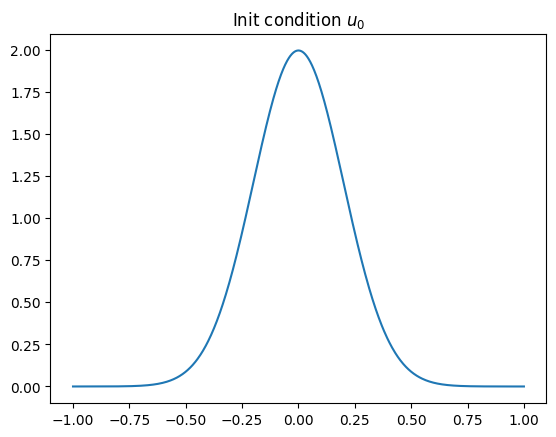

In [8]:
from jax.scipy.stats import norm
# true solution N(0,1)
sigma_init = 0.2 * jnp.ones((1))
mu_init = 0 * jnp.ones((1))

def u0(x):
    return jnp.squeeze(norm.pdf(x, loc=mu_init, scale=sigma_init))

plt.plot(train_data.domain[:, 1:2].sort(axis=0), vmap(u0, (0), 0)(train_data.domain[:, 1:2].sort(axis=0)))
plt.title(r"Init condition $u_0$")

## Model parameters

In [9]:
# Example III.29 is persistent with D = 1, r = 4,  g = 3
D = 1.
r = 4.
g = 3.
l = xmax - xmin

boundary_condition = "dirichlet"

if boundary_condition == "dirichlet":
    lambda_1 = jnp.pi ** 2 / l ** 2 * D - r
    omega_boundary_fun = lambda t_dx: 0 # cte func returning 0

elif boundary_condition == "neumann":
    lambda_1 = -r
    omega_boundary_fun = lambda t_dx: 0 # cte func returning 0

print("lambda_1 value:", lambda_1)

if lambda_1 < 0:
    # NOTE that if lambda_1 is just slightly negative the problem
    # is harder and the PINN might fall in extinction
    print("Persistance of the population is expected")
elif lambda_1 > 0:
    print("Extinction of the population is expected")


lambda_1 value: -1.5325988997276605
Persistance of the population is expected


A set of parameters as required by the losses' `evaluate` functions: a particular `Params` object that we instanciate next.

In [10]:
init_params_pinn = jinns.parameters.Params(
    nn_params=init_nn_params_pinn,
    eq_params={
        "D":jnp.array([D]),
        "r":jnp.array([r]),
        "g":jnp.array([g])
    }
)
init_params_spinn = jinns.parameters.Params(
    nn_params=init_nn_params_spinn,
    eq_params= {
        "D":jnp.array([D]),
        "r":jnp.array([r]),
        "g":jnp.array([g])
    }
)

## Loss construction

In [11]:
fisher_dynamic_loss = jinns.loss.FisherKPP(
    Tmax=Tmax
)


Loss for the PINN

In [12]:
loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1, initial_condition=1 * Tmax, boundary_loss=3 / 4 * Tmax
)

loss_pinn = jinns.loss.LossPDENonStatio(
    u=u_pinn,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    omega_boundary_fun=omega_boundary_fun,
    omega_boundary_condition=boundary_condition,
    initial_condition_fun=u0,
    params=init_params_pinn
)

Loss for the SPINN

In [13]:
loss_weights_spinn = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1, initial_condition=1, boundary_loss=1
)

loss_spinn = jinns.loss.LossPDENonStatio(
    u=u_spinn,
    loss_weights=loss_weights_spinn,
    dynamic_loss=fisher_dynamic_loss,
    omega_boundary_fun=omega_boundary_fun,
    omega_boundary_condition=boundary_condition,
    initial_condition_fun=u0,
    params=init_params_spinn
)

## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

### Train the PINN and plot loss values and solution

In [14]:
params_pinn = init_params_pinn
# Optimizer
import optax
tx = optax.adamw(learning_rate=1e-4)
n_iter = 15000
params_pinn, total_loss_list_pinn, loss_by_term_dict_pinn, train_data, loss, opt_state, _, _, _ = jinns.solve(
    init_params=params_pinn,
    data=train_data,
    optimizer=tx,
    loss=loss_pinn,
    n_iter=n_iter,
)


Compilation took
 3.3452398777008057 

[train] Iteration 0: loss value = 43.788673400878906
[train] Iteration 1000: loss value = 7.496972560882568
[train] Iteration 2000: loss value = 4.03712272644043
[train] Iteration 3000: loss value = 2.935800790786743
[train] Iteration 4000: loss value = 2.420548915863037
[train] Iteration 5000: loss value = 2.1022443771362305
[train] Iteration 6000: loss value = 1.606947422027588
[train] Iteration 7000: loss value = 1.5285606384277344
[train] Iteration 8000: loss value = 1.475148320198059
[train] Iteration 9000: loss value = 1.42229425907135
[train] Iteration 10000: loss value = 1.3833128213882446
[train] Iteration 11000: loss value = 1.3581576347351074
[train] Iteration 12000: loss value = 1.3419312238693237
[train] Iteration 13000: loss value = 1.3235028982162476
[train] Iteration 14000: loss value = 1.294947862625122

Stopping main optimization loop, cause: max iteration is reached

Training took
 69.79694724082947 


Final iteration 15000: tr

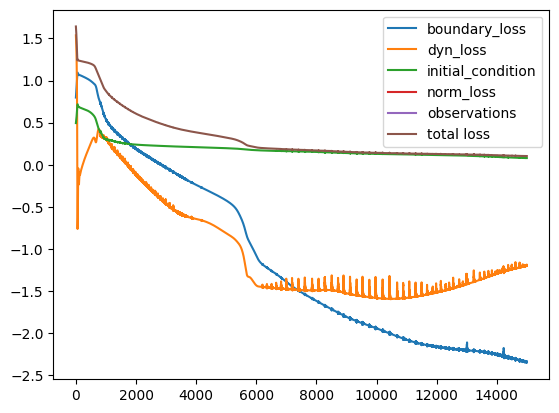

In [15]:
for loss_name, loss_values in loss_by_term_dict_pinn.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list_pinn), label="total loss")
plt.legend()
plt.show()

In [16]:
nx = 500
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 500
val_times = jnp.linspace(tmin, tmax, ntime)

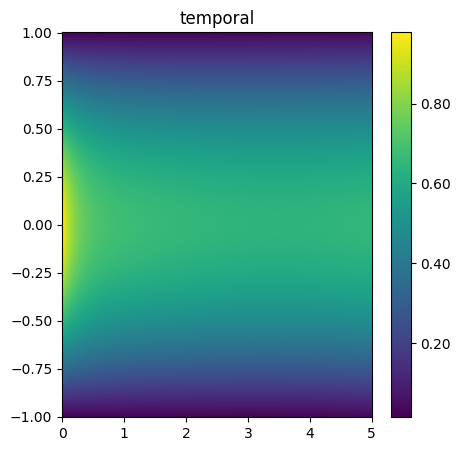

In [17]:
u_est_pinn = lambda t_x: u_pinn(t_x, params_pinn)
# same subkey
jinns.plot.plot1d_image(u_est_pinn, xdata=val_xdata, times=val_times, Tmax=Tmax, cmap="viridis", colorbar=True, figsize=(5, 5), title="temporal")

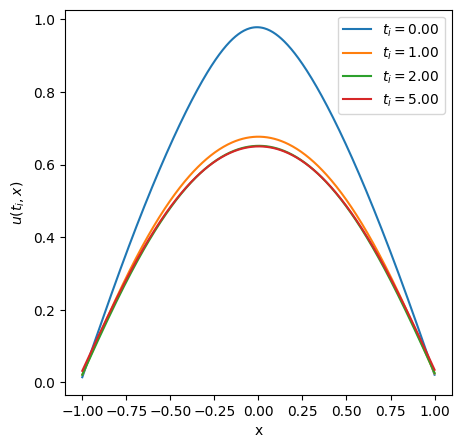

In [18]:
time_slices = [0, 0.2, 0.4, 1]
jinns.plot.plot1d_slice(u_est_pinn, xdata=val_xdata, time_slices=time_slices, Tmax=Tmax, figsize=(5, 5))

### Train the SPINN and plot loss values and solution

In [19]:
params_spinn = init_params_spinn
tx = optax.adam(learning_rate=1e-4)
n_iter = 30000
params_spinn, total_loss_list_spinn, loss_by_term_dict_spinn, train_data_spinn, loss_spinn, opt_state, _ , _, _ = jinns.solve(
    init_params=params_spinn,
    data=train_data_spinn,
    optimizer=tx,
    loss=loss_spinn,
    n_iter=n_iter
)


Compilation took
 9.208359956741333 

[train] Iteration 0: loss value = 1.950066328048706
[train] Iteration 1000: loss value = 0.4135836958885193
[train] Iteration 2000: loss value = 0.4027321934700012
[train] Iteration 3000: loss value = 0.6039077639579773
[train] Iteration 4000: loss value = 0.32482123374938965
[train] Iteration 5000: loss value = 0.386078417301178
[train] Iteration 6000: loss value = 0.25034594535827637
[train] Iteration 7000: loss value = 0.31243419647216797
[train] Iteration 8000: loss value = 0.3672891855239868
[train] Iteration 9000: loss value = 0.3630467355251312
[train] Iteration 10000: loss value = 0.32463693618774414
[train] Iteration 11000: loss value = 0.34599804878234863
[train] Iteration 12000: loss value = 0.23994404077529907
[train] Iteration 13000: loss value = 0.24632273614406586
[train] Iteration 14000: loss value = 0.25772589445114136
[train] Iteration 15000: loss value = 0.2763655185699463
[train] Iteration 16000: loss value = 0.3262262046337127

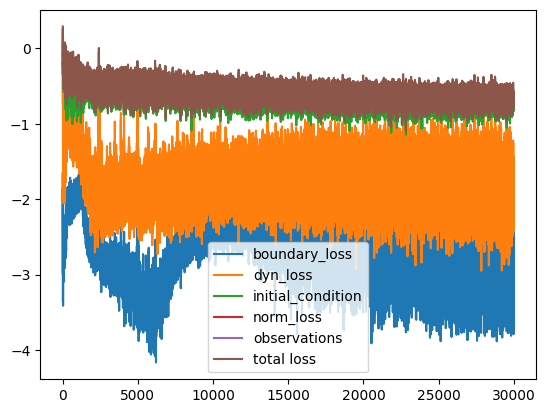

In [20]:
for loss_name, loss_values in loss_by_term_dict_spinn.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list_spinn), label="total loss")
plt.legend()
plt.show()

Plot the solution learned by the PINN

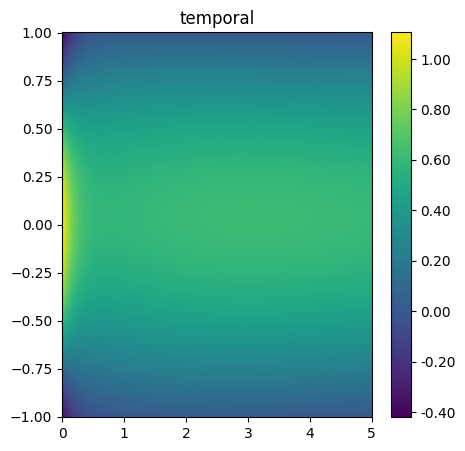

In [21]:
u_est_spinn = lambda t_x: u_spinn(t_x, params_spinn)
# same subkey
jinns.plot.plot1d_image(u_est_spinn, xdata=val_xdata, times=val_times, Tmax=Tmax, cmap="viridis", colorbar=True, figsize=(5, 5), title="temporal", spinn=True)

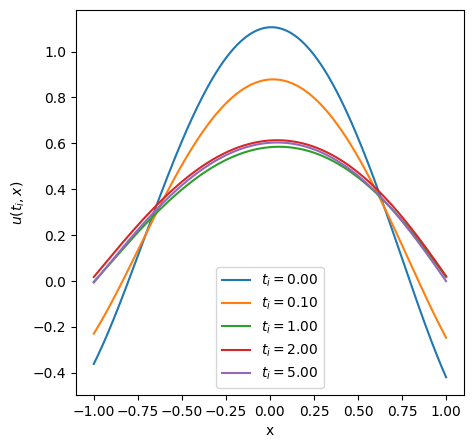

In [22]:
time_slices = [0, 0.02, 0.2, 0.4, 1]
jinns.plot.plot1d_slice(u_est_spinn, xdata=val_xdata, time_slices=time_slices, Tmax=Tmax, figsize=(5, 5), spinn=True)

## Conclusion

Solving this particular Fisher KPP has been possible without any specific fine-tuning with the PINN while the SPINN architecture seems tricky to tune (is it because of the initial condition?)

## Compare with the analytical solution
See Fig III.1 p 73 of the book _Modèles de réaction-diffusion pour l'écologie spatiale_ by Lionel Roques. Our estimation seems good. Note that we have a slightly different Gaussian initial condition as the book does not explicit their choice for `u0`.